Data shape: (951262, 21)
Checkpoint keys: dict_keys(['model', 'layer'])


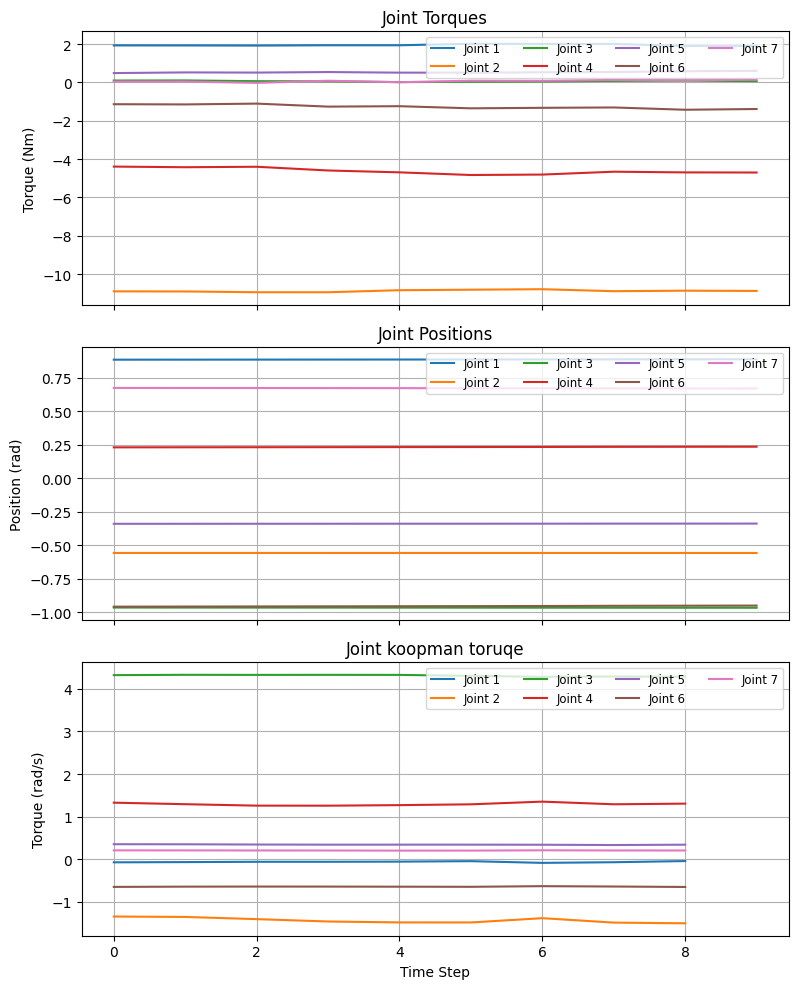

In [2]:
import numpy as np
import ipdb
import matplotlib.pyplot as plt
import sys
sys.path.append("../utility")
from inference import recover_controls_for_trajectory, load_koopman_model
import torch
import pandas as pd
# Replace 'your_file.txt' with the actual path to your file
#data = np.loadtxt('../data/datasets/kinova_data/output_20250402_205831.txt')
file_path = 'output_20250402_205831.txt'
df = pd.read_csv(f'../data/datasets/kinova_data/{file_path}', 
                        delimiter=' ', 
                        header=None,
                        on_bad_lines='skip', 
                        engine='python')
data = df.to_numpy()

# Check the shape
print("Data shape:", data.shape)  # should print (N, 21)

num_vaild_data = 10
max_start = data.shape[0] - num_vaild_data
start_idx = np.random.randint(0, max_start)

# Use first 1000 rows and first 7 columns
torque_data = data[start_idx:start_idx+num_vaild_data, :7]
position_data = data[start_idx:start_idx+num_vaild_data, 7:14]  # columns 7–13
velocity_data = data[start_idx:start_idx+num_vaild_data, 14:21]    # columns 14–20
state_data = data[start_idx:start_idx+num_vaild_data, 7:21] 

# recover trajectorty
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = load_koopman_model("../log/best_models/Kinova/best_model_nonorm_Kinova_1024_1_1.pth",device)

koopman_torque_data = recover_controls_for_trajectory(state_data,net,device=device).detach().cpu().numpy()
# ipdb.set_trace()

# Create square layout with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Plot torques
for i in range(7):
    axs[0].plot(torque_data[:, i], label=f'Joint {i+1}')
axs[0].set_title('Joint Torques')
axs[0].set_ylabel('Torque (Nm)')
axs[0].legend(loc='upper right', ncol=4, fontsize='small')
axs[0].grid(True)

# Plot positions
for i in range(7):
    axs[1].plot(position_data[:, i], label=f'Joint {i+1}')
axs[1].set_title('Joint Positions')
axs[1].set_ylabel('Position (rad)')
axs[1].legend(loc='upper right', ncol=4, fontsize='small')
axs[1].grid(True)

# # Plot velocities
# for i in range(7):
#     axs[2].plot(velocity_data[:, i], label=f'Joint {i+1}')
# axs[2].set_title('Joint Velocities')
# axs[2].set_xlabel('Time Step')
# axs[2].set_ylabel('Velocity (rad/s)')
# axs[2].legend(loc='upper right', ncol=4, fontsize='small')
# axs[2].grid(True)

# Plot velocities
for i in range(7):
    axs[2].plot(koopman_torque_data[:, i], label=f'Joint {i+1}')
axs[2].set_title('Joint koopman toruqe')
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('Torque (rad/s)')
axs[2].legend(loc='upper right', ncol=4, fontsize='small')
axs[2].grid(True)

plt.tight_layout()
plt.show()